## Package and Data Preparation

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  2 17:27:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
import os
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import regex
import string
import unicodedata
import html
from html.parser import HTMLParser
import matplotlib.pyplot as plt

In [7]:
import nltk
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [9]:
!pip install transformers

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from torchtext import data
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
## Read the Data
DF_ = pd.read_csv('Steam_Clean_Data.csv')
DF_.head()
DF_ = DF_.drop("authentic", axis = 1)

In [12]:
DF, _ = train_test_split(DF_, train_size = 2000, stratify=DF_['recommendation'], random_state = 580)

In [13]:
DF.reset_index(drop = True)

review   recommendation
0      gt enter random server gt die gt respawn gt m...      Recommended
1     a from me at best the third person as usual ru...  Not Recommended
2     product received for free good i love it but u...      Recommended
3     how to lose hours of lifenice shot nice shot n...      Recommended
4              it s the simpsons hit and run remastered      Recommended
...                                                 ...              ...
1995  very much liked the game but dont like how the...      Recommended
1996                        the best game u should have      Recommended
1997  wow i keep getting my face kicked in but boy d...      Recommended
1998                              holy rocked my balls       Recommended
1999  very fun game how ever long loading times on s...      Recommended

[2000 rows x 2 columns]

Now we have the row dataframe that we wanted, with those attributes(review content and labels(recommended or not))! We can move on to the next step which is cleaning and tokenizing data.

## Cleaning and Tokenizing

We need to build a preprocessor first tokenize the reviews.

In [14]:
class Preprocessor(BaseEstimator, TransformerMixin):


    def __init__(self, lower=True, strip=True, remove_punct=True, 
                 remove_diacritics=True, unicode_form='NFC', 
                 remove_stop=False, stem_tokens=False, 
                 lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

Now we will use the preprocessor to tokenize the reviews

In [15]:
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=True)
DF['review']=DF['review'].apply(my_preprocessor.tokenize)
DF.head()

review   recommendation
299184  [gt, enter, random, server, gt, die, gt, respa...      Recommended
253607  [best, third, person, usual, ruin, every, elem...  Not Recommended
301461  [product, receive, free, good, love, u, never,...      Recommended
49198   [lose, hour, lifenice, shot, nice, shot, nice,...      Recommended
135471                    [simpson, hit, run, remastered]      Recommended

Let's check the data type of the columns in this dataframe

In [16]:
DF.dtypes

review            object
recommendation    object
dtype: object

We need to change our label to category type

In [17]:
DF['recommendation']=DF['recommendation'].astype('category')

Before we split the dataframe into train and test data, I will save it to a csv file firstly.

In [18]:
DF.to_csv('DF_Tokenize.csv',header=True,index=False)

## Prepare training and test data

In [19]:
DF = pd.read_csv('DF_Tokenize.csv')

In [20]:
DF.head()

review   recommendation
0  ['gt', 'enter', 'random', 'server', 'gt', 'die...      Recommended
1  ['best', 'third', 'person', 'usual', 'ruin', '...  Not Recommended
2  ['product', 'receive', 'free', 'good', 'love',...      Recommended
3  ['lose', 'hour', 'lifenice', 'shot', 'nice', '...      Recommended
4            ['simpson', 'hit', 'run', 'remastered']      Recommended

In [21]:
DF['review'] = DF['review'].apply(lambda x: ' '.join(eval(x)))

# Bert

In [22]:
texts=DF['review']
labels=DF['recommendation']

In [23]:
label_to_index = {}
index_to_label = {}
label_lst = list(set(labels))
for i in range(len(label_lst)):
    label = label_lst[i]
    label_to_index[label] = i
    index_to_label[i] = label

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [25]:
input_ids = []
for text in texts:
    encoded_sent = tokenizer.encode(text,
                                    add_special_tokens=True, 
                                    max_length=128,
                                    truncation=True)
    input_ids.append(encoded_sent)

In [26]:
print('Max sentence length: ', max([len(sent) for sent in input_ids]))

Max sentence length:  128


In [27]:
input_ids = pad_sequences(input_ids, maxlen=128, dtype="long", 
                          value=0, truncating="post", padding="post")

In [28]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [29]:
labels = [label_to_index[label] for label in labels]

In [30]:
train_input_ids, test_input_ids, train_labels, test_labels \
    = train_test_split(input_ids, labels, test_size=0.3, random_state=42)

train_attention_masks, test_attention_masks, train_labels, test_labels \
    = train_test_split(attention_masks, labels, test_size=0.3, random_state=42)

In [31]:
train_input_ids = torch.tensor(train_input_ids)
test_input_ids = torch.tensor(test_input_ids)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

train_attention_masks = torch.tensor(train_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)

In [32]:
batch_size = 32
# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [33]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = len(label_lst),  
    output_attentions = False, 
    output_hidden_states = False
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU


In [35]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [36]:
dim_reducer = TSNE(n_components=2)

def visualize_layerwise_embeddings(hidden_states,masks,labels,epoch,title,layers_to_visualize):

    !mkdir -p /tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    
    fig = plt.figure(figsize=(30,20)) #each subplot of size 6x6, each row will hold 4 plots
    title_name = "Epoch "+str(epoch)+" Embeddings"
    plt.suptitle(title_name, fontsize = 30, y = 0.92)
    labels = labels.numpy().reshape(-1)
    #Pic = pd.DataFrame()
    for i,layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]
        
        layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.detach().numpy())
        
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})
        #Pic = pd.concat([Pic,df],ignore_index = True)
        
        fig = plt.subplot(331+i)
        plt.subplots_adjust(wspace =0.4, hspace =0.4)
        sns.scatterplot(data=df,x='x',y='y',hue='label')
        name = "layer "+str(layer_i+1)
        plt.title(name, fontsize = 20)
        
    #sns.scatterplot(data=Pic,x='x',y='y',hue='label')
    plt.savefig('vis'+str(epoch)+'.png')    

In [37]:
"""dim_reducer = TSNE(n_components=2)
#dim_reducer = PCA(n_components=2)

def visualize_layerwise(hidden_states,masks,ys,epoch,title,layers_to_visualize=[0,1,2,3,8,9,10,11]):
    print('visualize_layerwise_embeddings for',title,'epoch',epoch)
    global dim_reducer
    !mkdir -p /tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6
    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]
    ys = ys.numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):
        layer_hidden_states = hidden_states[layer_i]
        averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1),masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
        df.label = df.label.astype(int)
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])
        fig.suptitle(f"{title}: epoch {epoch}")
        ax[i].set_title(f"layer {layer_i+1}")
    plt.savefig(f'/tmp/plots/{title}/{epoch}',format='png',pad_inches=0)
    #print()"""


'dim_reducer = TSNE(n_components=2)\n#dim_reducer = PCA(n_components=2)\n\ndef visualize_layerwise(hidden_states,masks,ys,epoch,title,layers_to_visualize=[0,1,2,3,8,9,10,11]):\n    print(\'visualize_layerwise_embeddings for\',title,\'epoch\',epoch)\n    global dim_reducer\n    !mkdir -p /tmp/plots/{title}\n    num_layers = len(layers_to_visualize)\n    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6\n    ax = [fig.add_subplot(num_layers/4,4,i+1) for i in range(num_layers)]\n    ys = ys.numpy().reshape(-1)\n    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):\n        layer_hidden_states = hidden_states[layer_i]\n        averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1),masks.sum(dim=1,keepdim=True))\n        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())\n        df = pd.DataFrame.from_dict({\'x\':layer_dim_reduced_vectors[:,0],\'y\':layer_dim_reduced_vectors[:,1],\'label\


Epoch 1
Training...
Average training loss: 0.12


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 2
Training...
Average training loss: 0.10


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 3
Training...
Average training loss: 0.07


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 4
Training...
Average training loss: 0.06


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 5
Training...
Average training loss: 0.05


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 6
Training...
Average training loss: 0.04


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 7
Training...
Average training loss: 0.03


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 8
Training...
Average training loss: 0.03


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 9
Training...
Average training loss: 0.03


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea


Epoch 10
Training...
Average training loss: 0.03


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

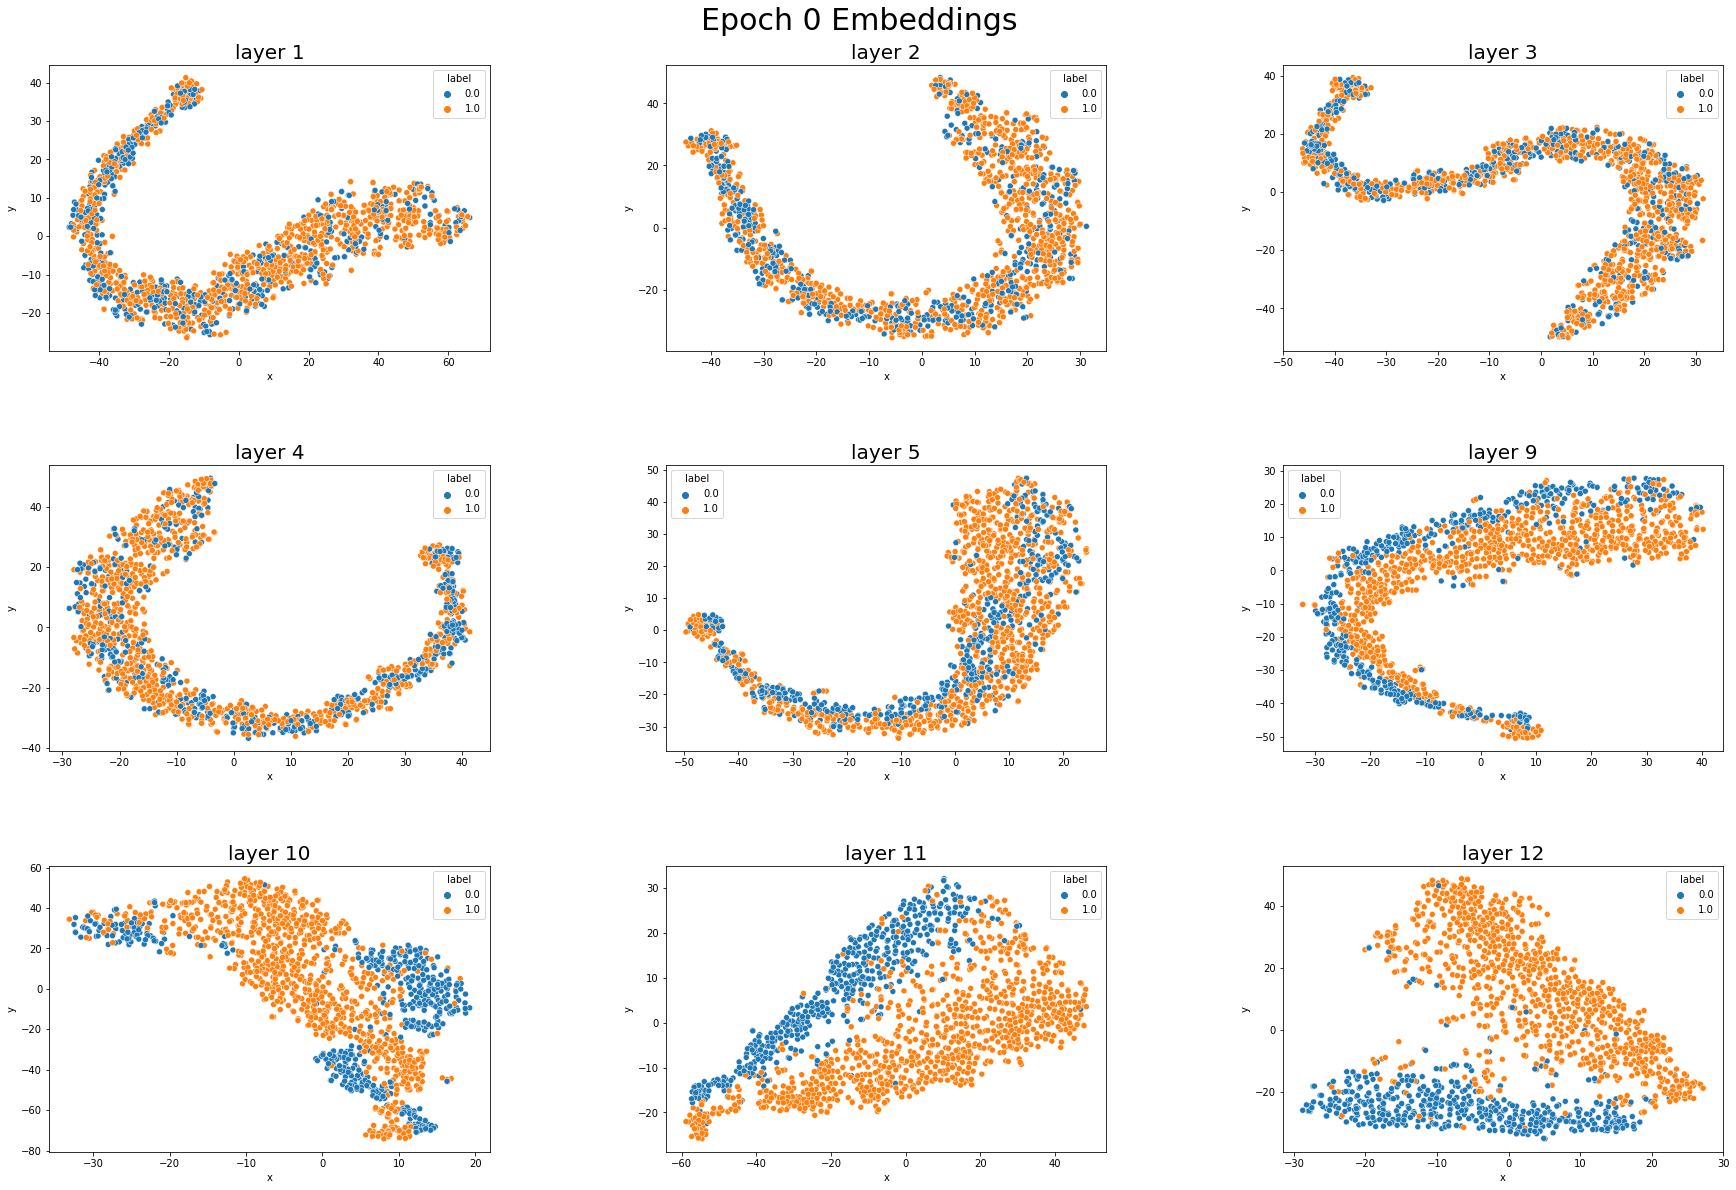

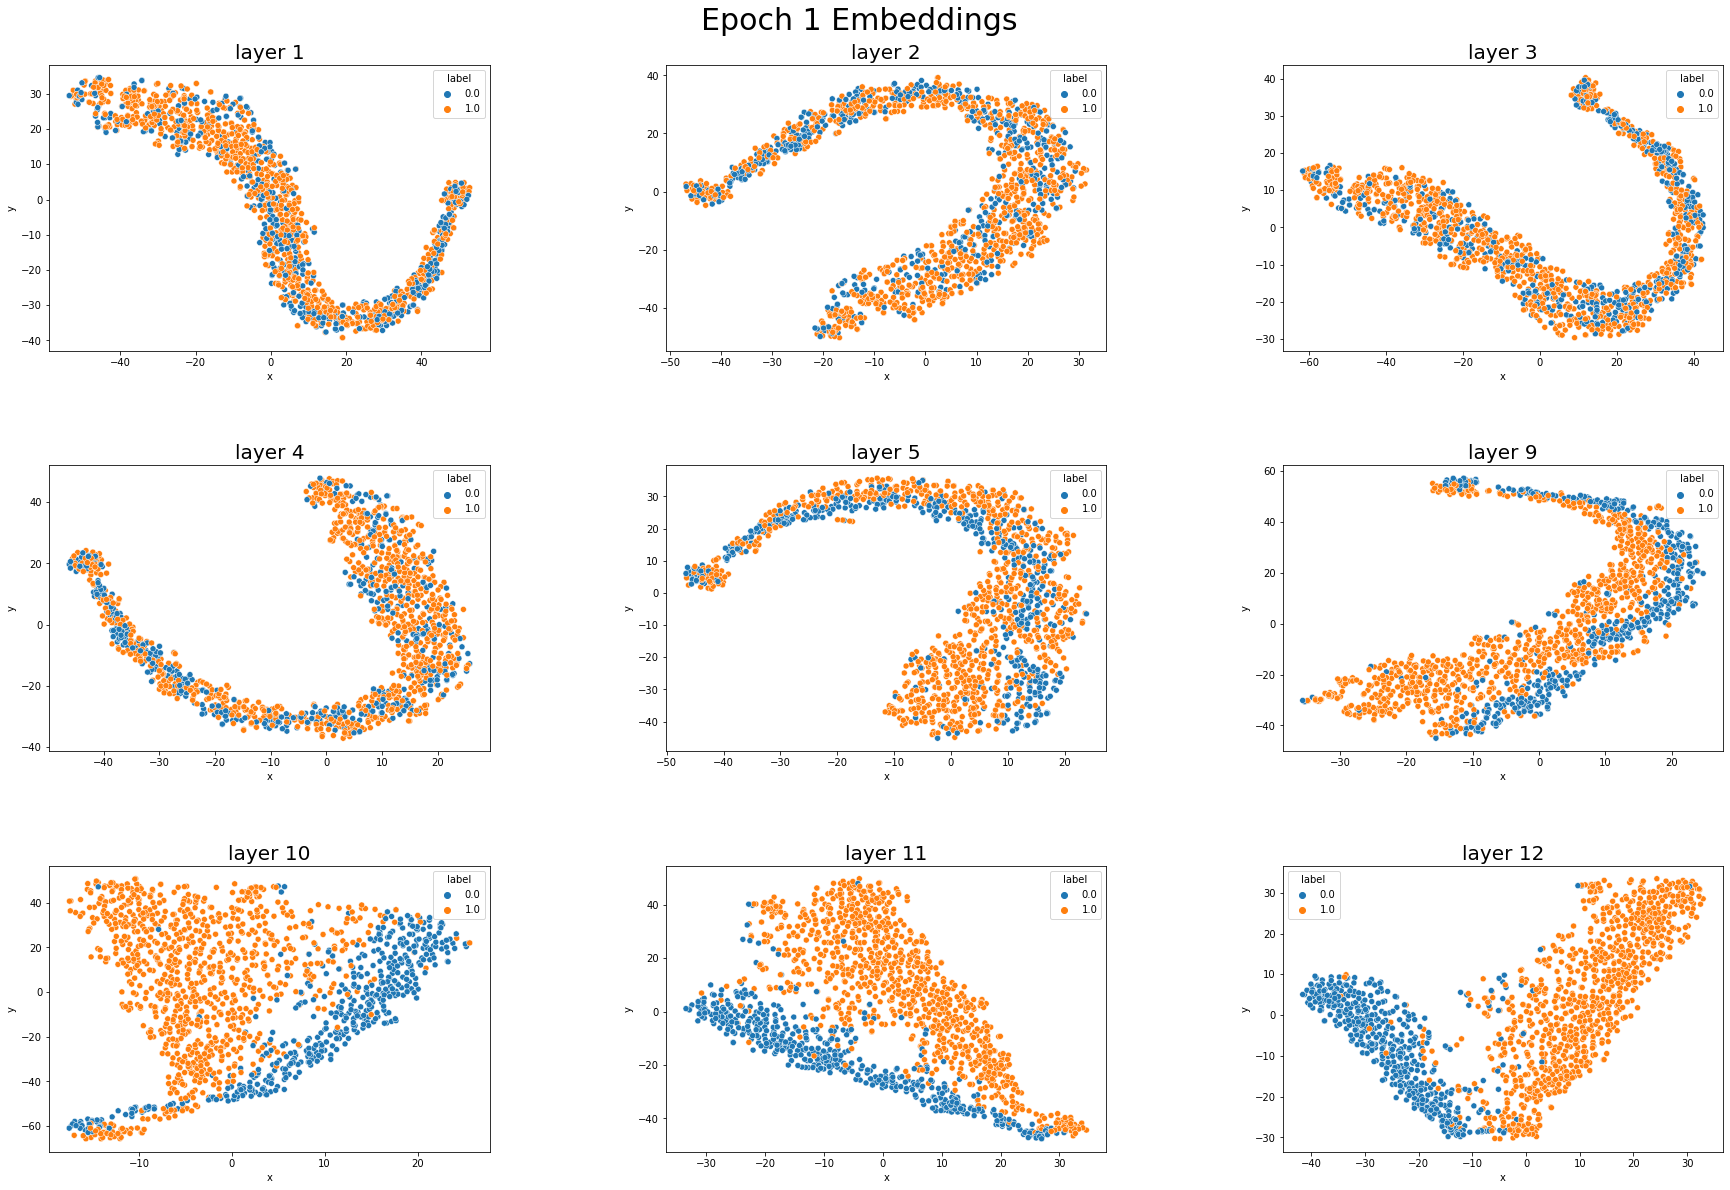

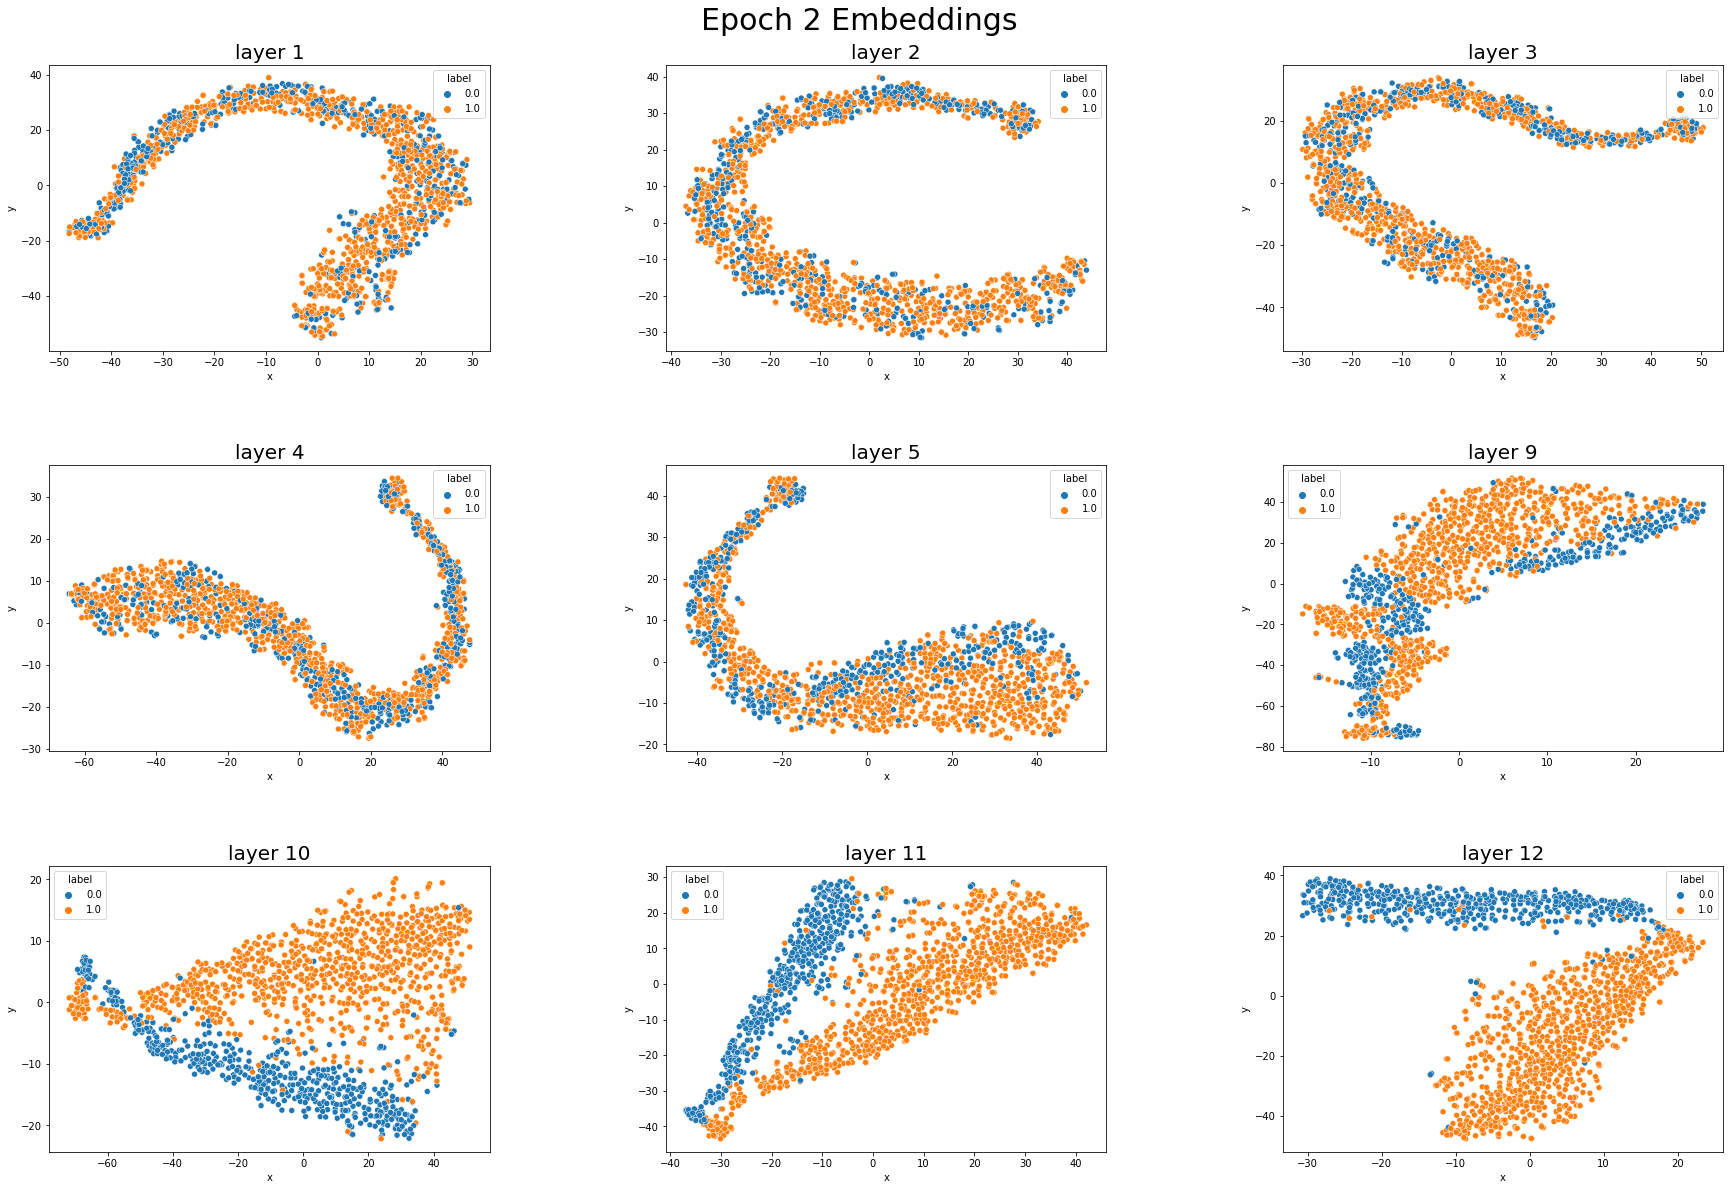

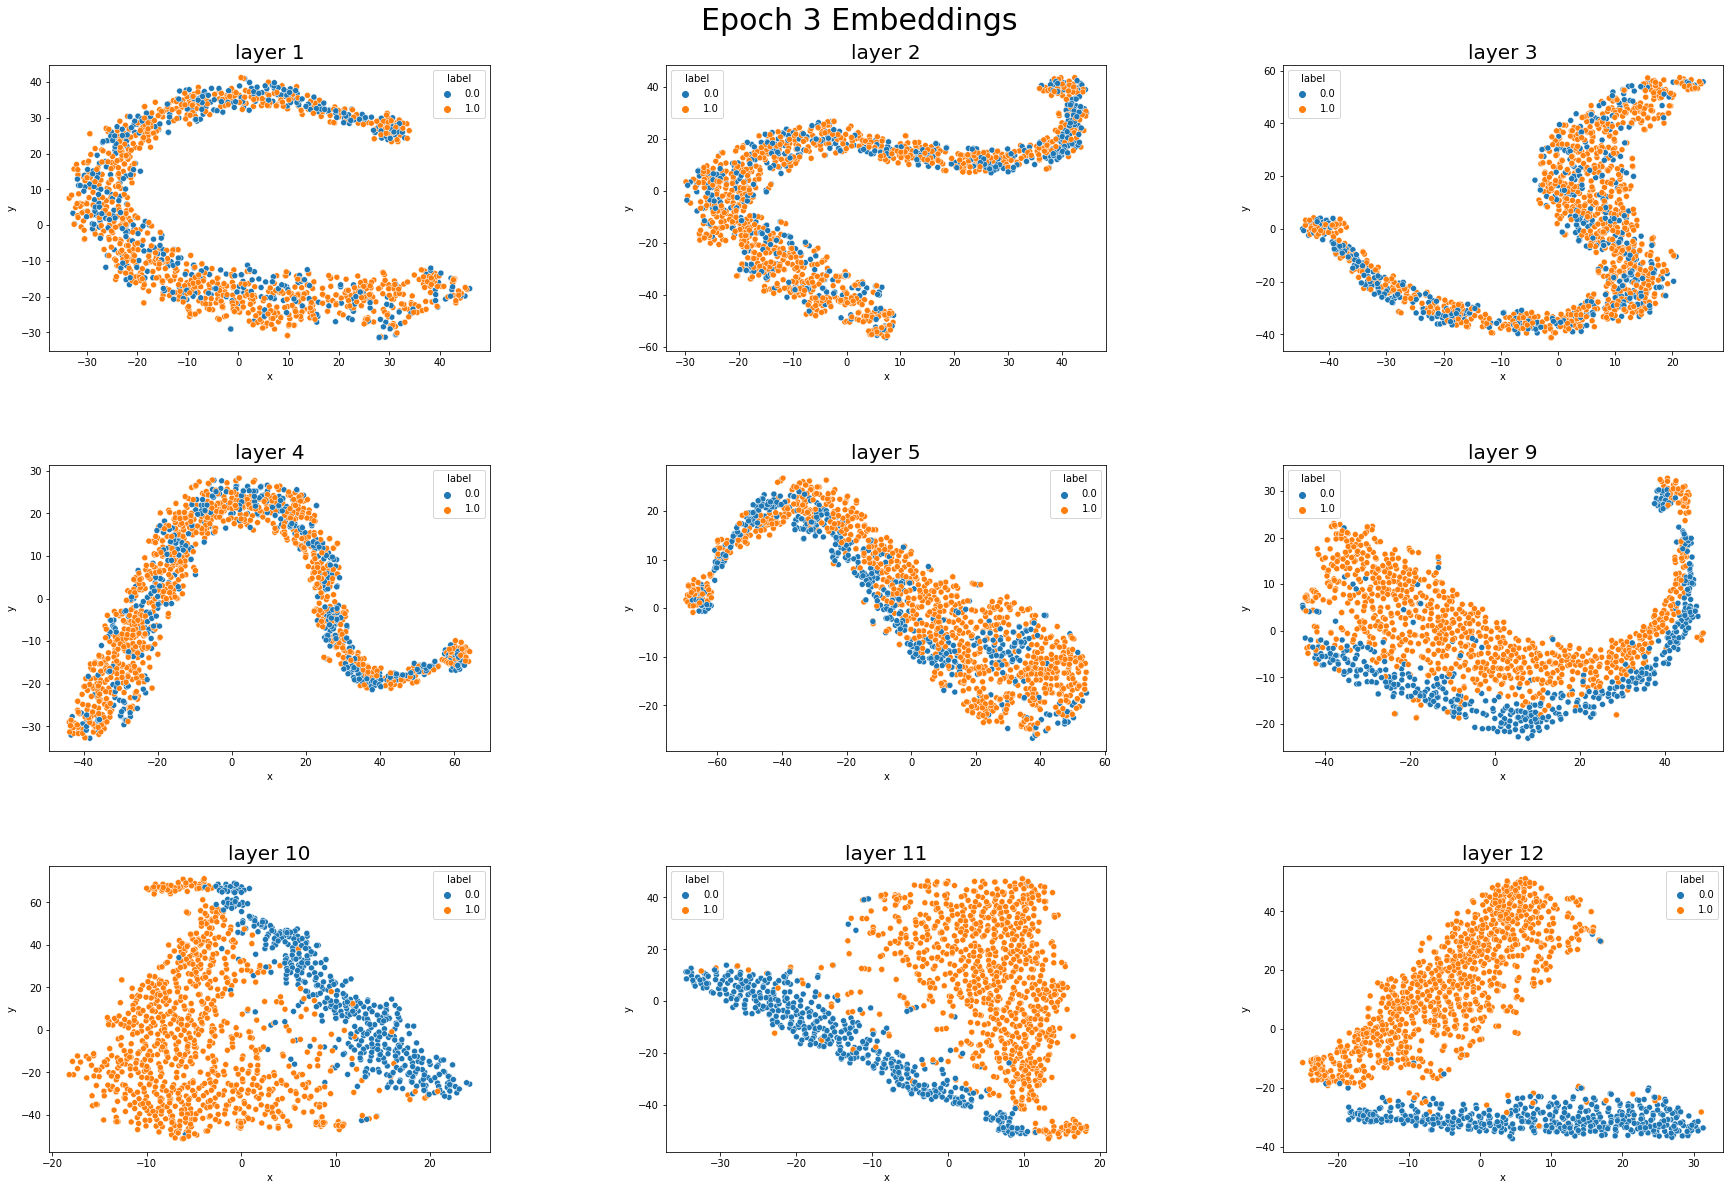

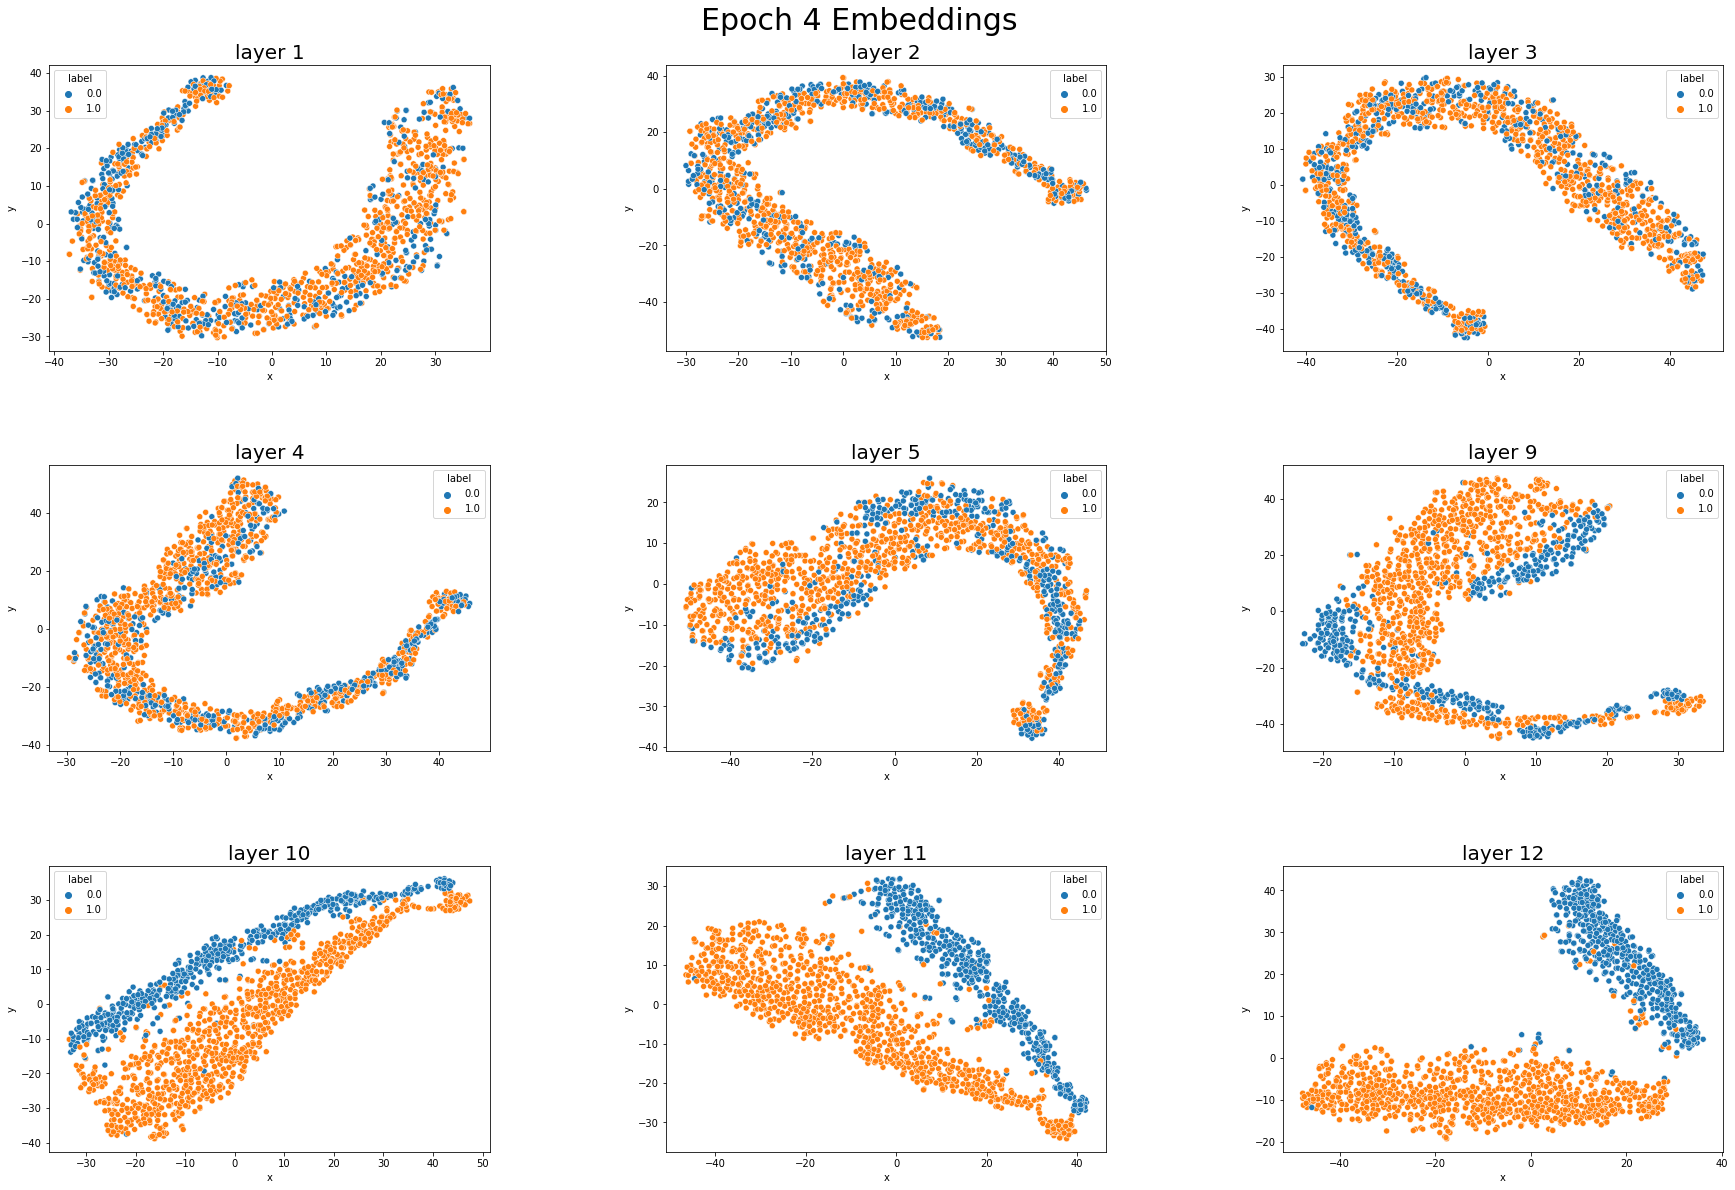

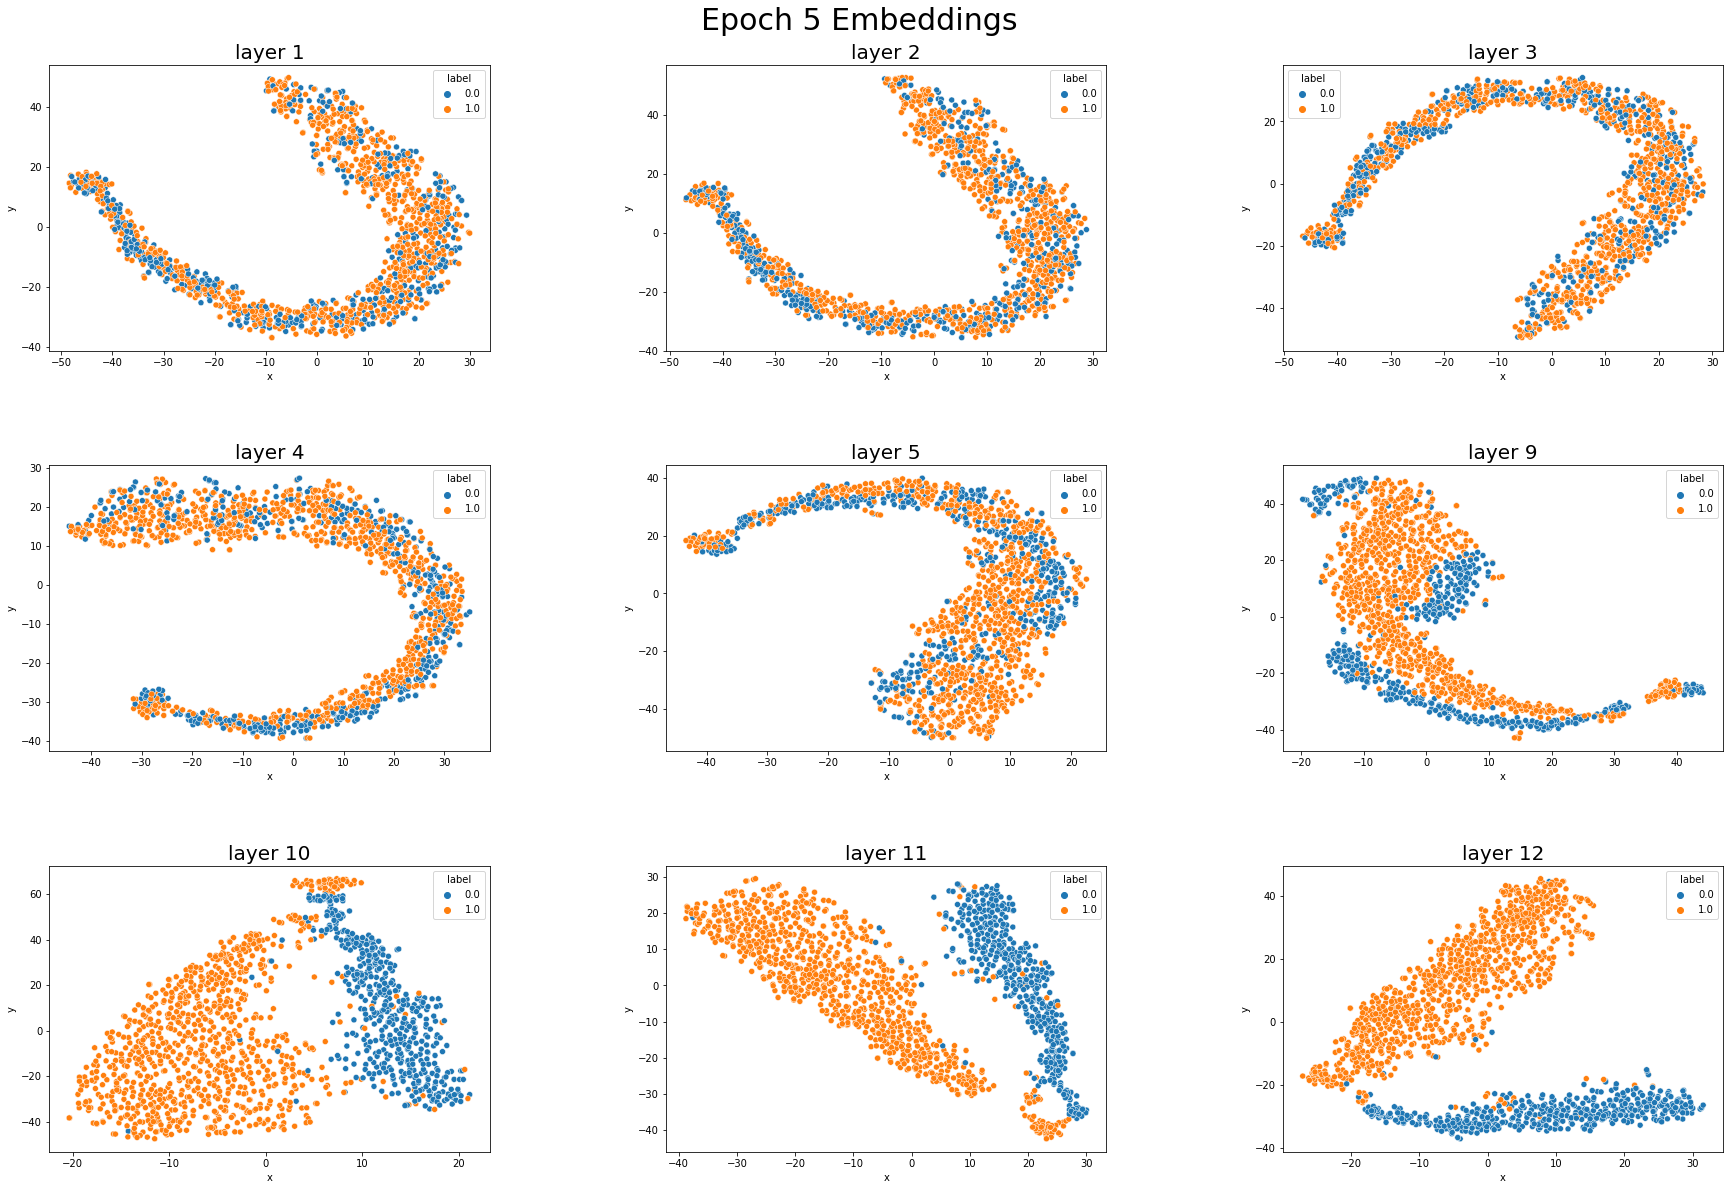

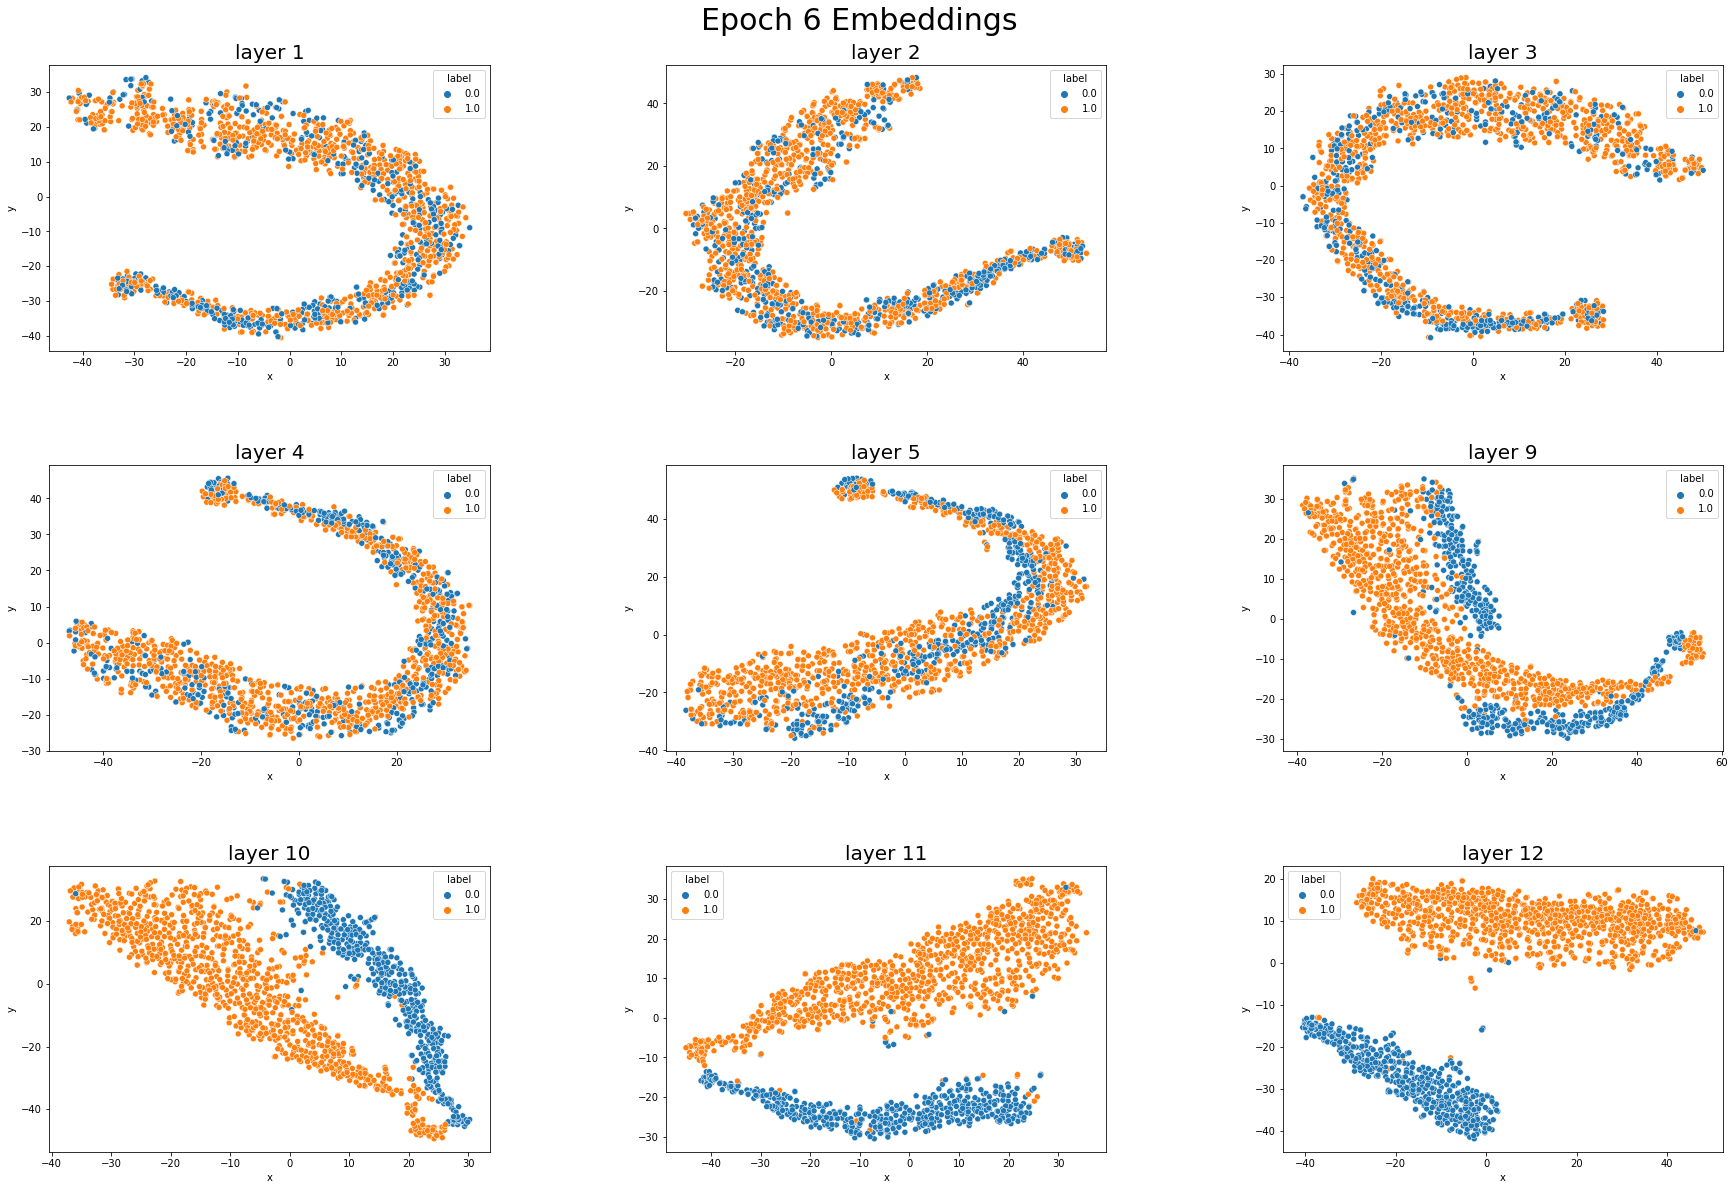

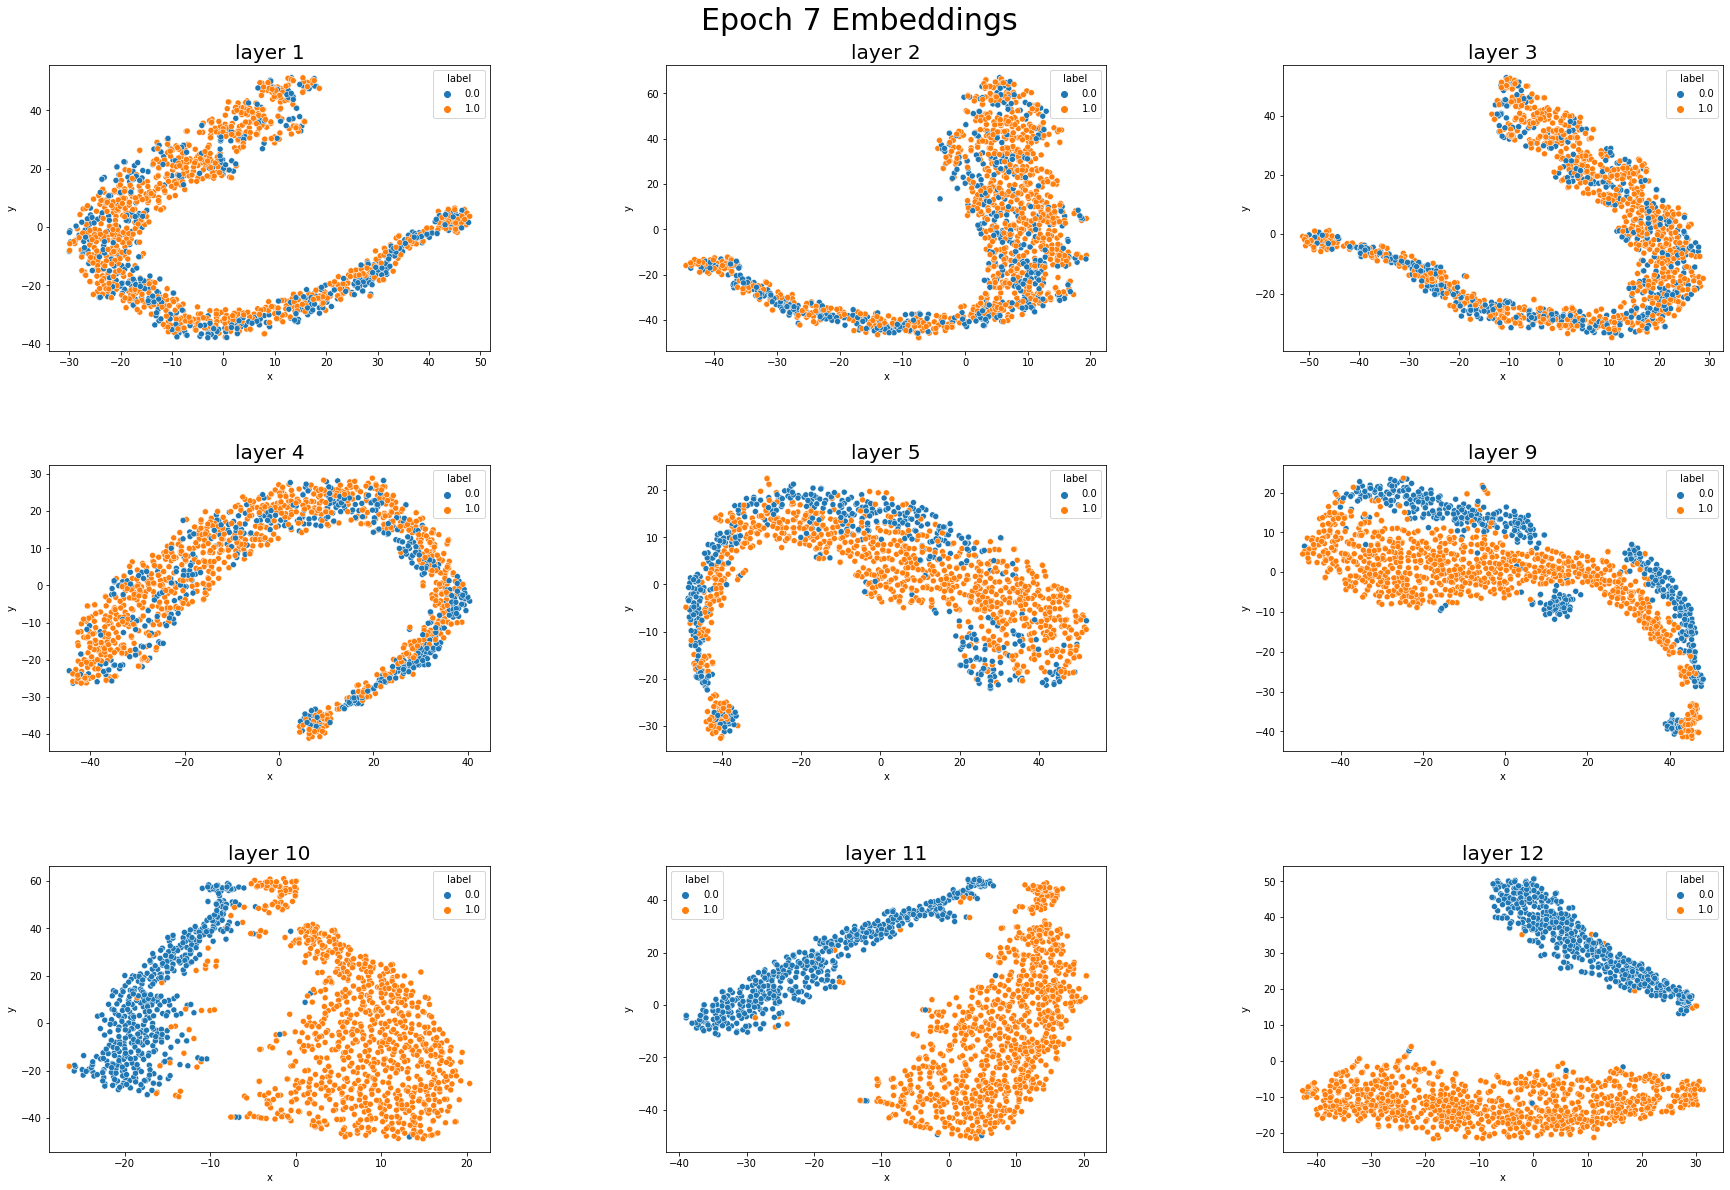

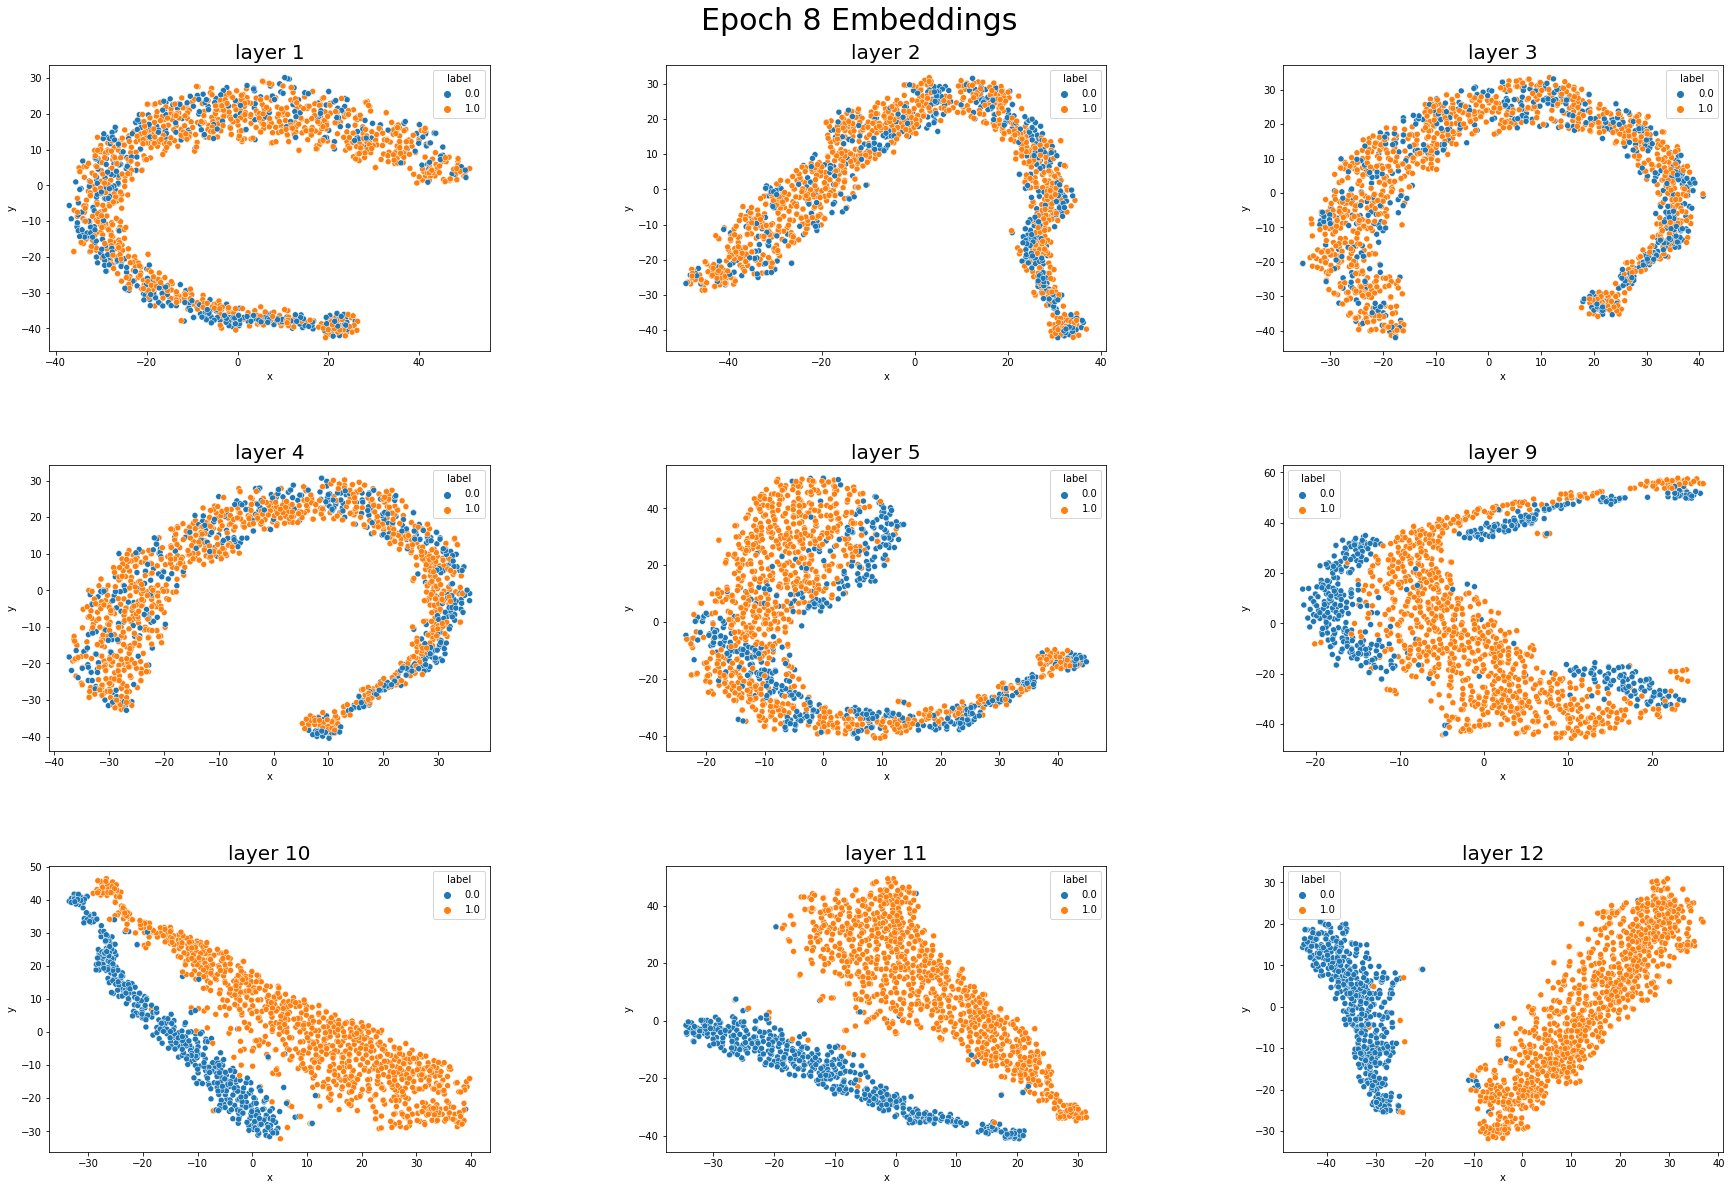

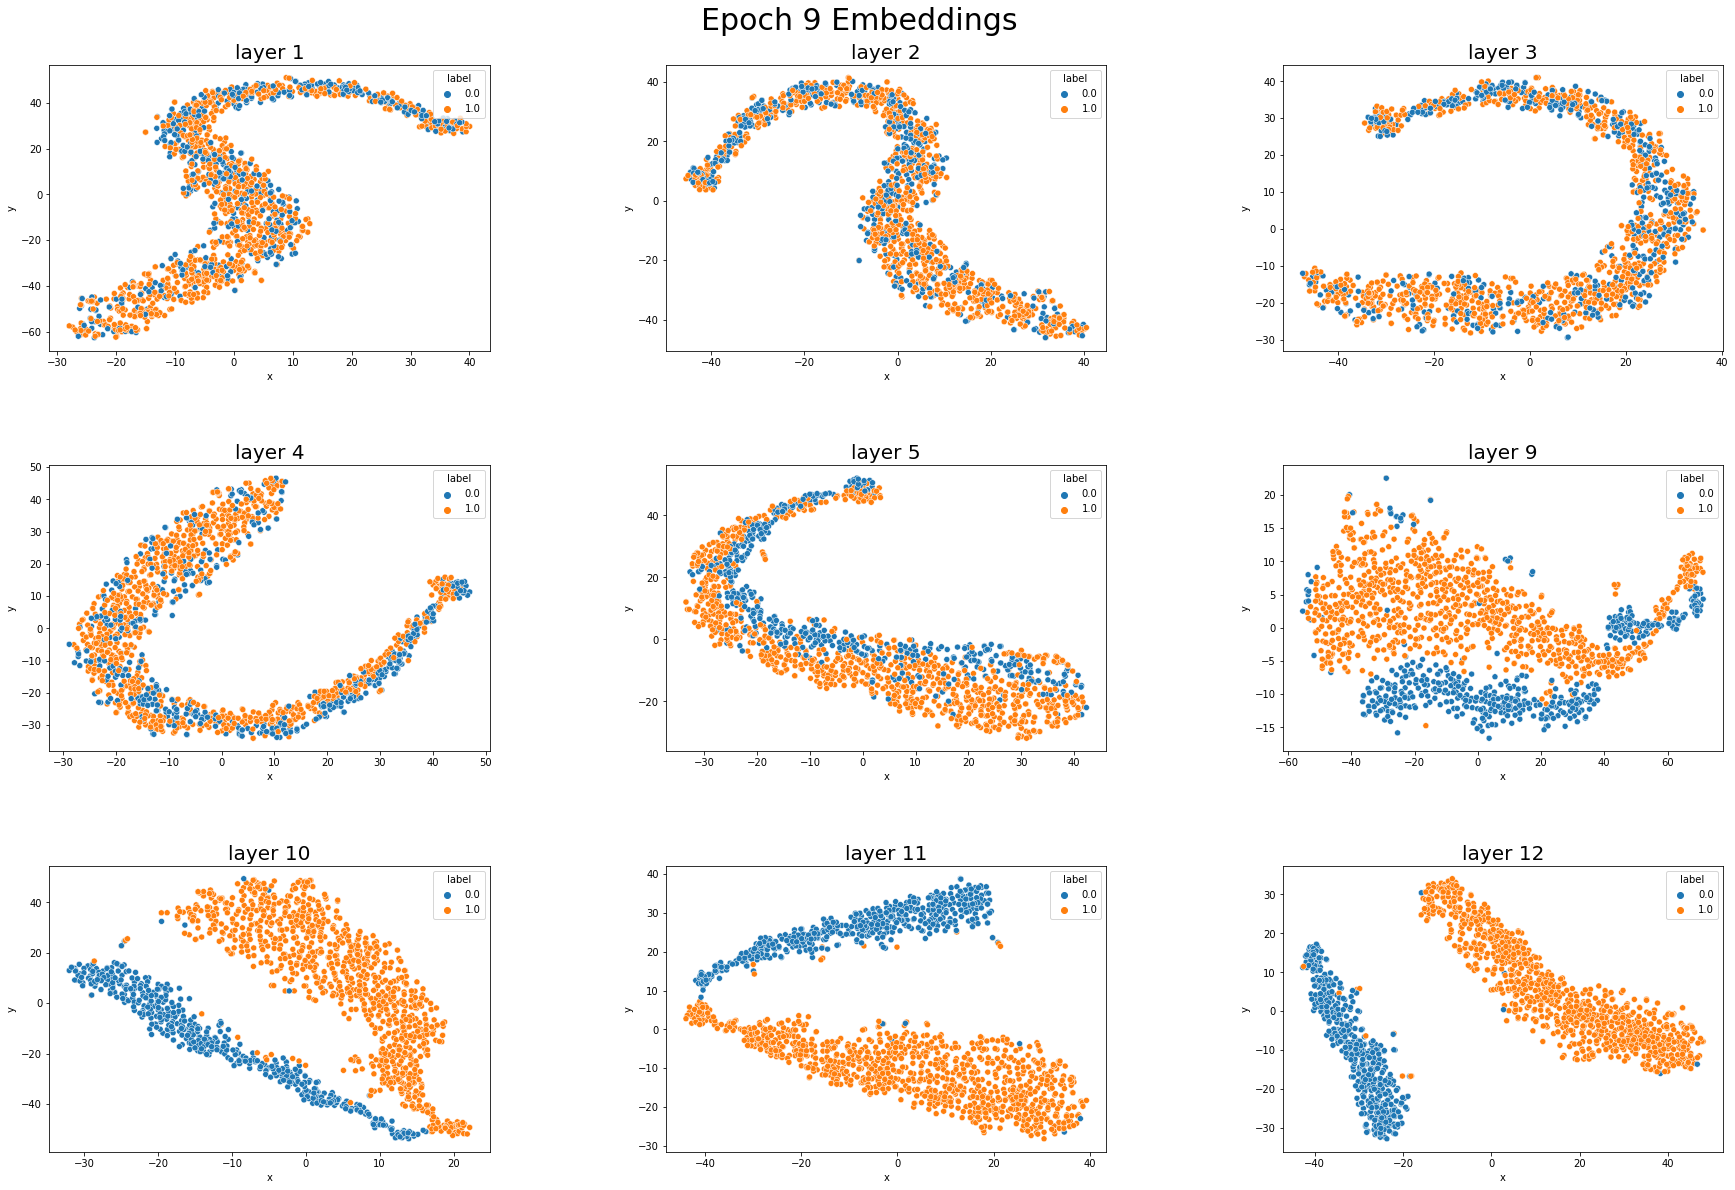

In [39]:
for epoch_i in range(10):
    print("")
    print('Epoch {}'.format(epoch_i + 1))
    print('Training...')
    
    total_loss = 0
    model.train()

    train_masks,train_ys = torch.zeros(0,128),torch.zeros(0,1)
    train_hidden_states = None

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        outputs = model(b_input_ids, 
                        token_type_ids=None,
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        output_hidden_states=True,
                        return_dict=True)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        hidden_states = outputs.hidden_states[1:]
        train_masks = torch.cat([train_masks,b_input_mask.cpu()])
        train_ys = torch.cat([train_ys,b_labels.cpu().view(-1,1)])
        
        if type(train_hidden_states) == type(None):
          train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
        else:
          train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))
        
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    visualize_layerwise_embeddings(hidden_states=train_hidden_states,
                                 masks=train_masks,
                                 labels=train_ys,
                                 epoch=epoch_i,
                                 title='train_data',
                                 layers_to_visualize=[0,1,2,3,4,8,9,10,11])

In [40]:
model.eval()
preds_test = []
labels_test = []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    preds_test += list(preds_flat)
    labels_test += list(labels_flat)

In [41]:
print("Accuracy:", accuracy_score(labels_test, preds_test))
print("Precision:", precision_score(labels_test, preds_test, average="macro"))
print("Recall:", recall_score(labels_test, preds_test, average="macro"))
print("Macro F1:", f1_score(labels_test, preds_test, average="macro"))

Accuracy: 0.8133333333333334
Precision: 0.783298572772257
Recall: 0.7706935851514165
Macro F1: 0.7763459183130093


In [42]:
labels_test_txt = list(map(lambda x: index_to_label[x], labels_test))
preds_test_txt = list(map(lambda x: index_to_label[x], preds_test))
cnf_matrix = confusion_matrix(labels_test_txt, preds_test_txt, labels=['Recommended', 'Not Recommended'])

Text(91.68, 0.5, 'predicted label')

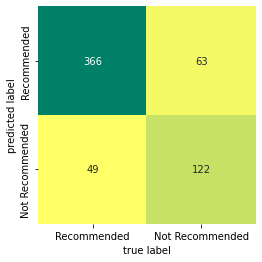

In [43]:
plt.grid(False)
#mat = confusion_matrix(y_test, nb_labels, labels=['Extremely Popular', 'Very Popular'])

#plt.figure(figsize=(10, 8))
sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Recommended', 'Not Recommended'],
            yticklabels=['Recommended', 'Not Recommended'], cmap = 'summer_r')
plt.xlabel('true label')
plt.ylabel('predicted label')
#plt.savefig('reddit-nb-cm.png')

In [44]:
print(clsr(labels_test, preds_test, target_names=['Recommended', 'Not Recommended']))

                 precision    recall  f1-score   support

    Recommended       0.71      0.66      0.69       185
Not Recommended       0.85      0.88      0.87       415

       accuracy                           0.81       600
      macro avg       0.78      0.77      0.78       600
   weighted avg       0.81      0.81      0.81       600



For BERT model, it is different from logistic regression. We pass in the textual data and BERT will tokenize the texts by inserting some tokens to indicate the start and end of the sentence. BERT will also use mask to separate different sentences. Each token will be mapped to a token id. Position embeddings are also added to indicate the position of each token. After tokenizing the input, the token ids as well as the attention masks will be fed into classifier.

## Conclusion

Based on the evaluation on the test set, we can observe that logistic regression and LinearSVC is slightly better than BERT model, Naive Bayes and Decision Tree. This could be because that the dataset is not a complex task. For more complex tasks, BERT model can be expected to perform better. But overall, all the models we trained made pretty accurate predictions on this dataset.

In the future, we could improve by incorporating word2vec embeddings instead of using TF-IDF and
count vectorizers, or include more feature engineering techniques before modeling.